# Chapter 11: Partial differential equations

Robert Johansson

Source code listings for [Numerical Python - Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib](https://www.apress.com/us/book/9781484242452) (ISBN 978-1-484242-45-2).

In [1]:
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import mpl_toolkits.mplot3d

In [4]:
import scipy.sparse as sp

In [5]:
import scipy.sparse.linalg

In [6]:
import scipy.linalg as la

## Finite-difference method

## 1d example

Heat equation: 

$$-5 = u_{xx}, u(x=0) = 1, u(x=1) = 2$$

$$
u_{xx}[n] = (u[n-1] - 2u[n] + u[n+1])/dx^2
$$

In [7]:
N = 5

In [8]:
u0 = 1
u1 = 2

In [9]:
dx = 1.0 / (N + 1)

In [10]:
A = (np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)) / dx**2

In [11]:
A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

In [12]:
d = -5 * np.ones(N)
d[0] -= u0 / dx**2
d[N-1] -= u1 / dx**2

In [13]:
u = np.linalg.solve(A, d)

In [14]:
x = np.linspace(0, 1, N+2)

In [15]:
U = np.hstack([[u0], u, [u1]])

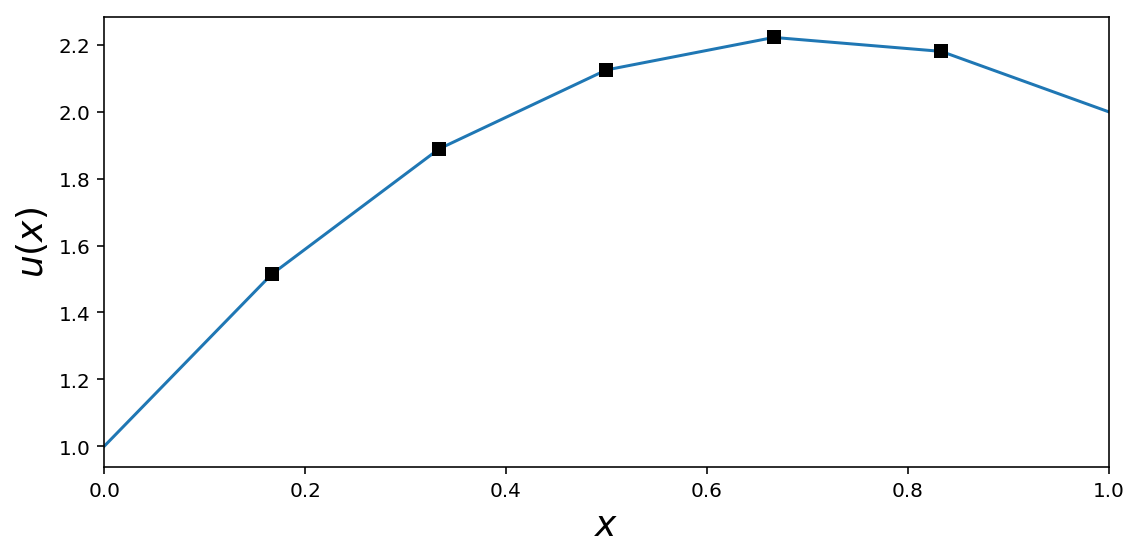

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, U)
ax.plot(x[1:-1], u, 'ks')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u(x)$", fontsize=18)
fig.savefig("ch11-fdm-1d.pdf")
fig.tight_layout();

## 2d example

laplace equation: $u_{xx} + u_{yy} = 0$

on boundary:

$$
u(x=0) = u(x=1) = u(y = 0) = u(y = 1) = 10
$$

$$
u_{xx}[m, n] = (u[m-1, n] - 2u[m,n] + u[m+1,n])/dx^2
$$

$$
u_{yy}[m, n] = (u[m, n-1] - 2u[m,n] + u[m,n+1])/dy^2
$$

final equation

$$
0 
= 
(u[m-1 + N n] - 2u[m + N n] + u[m+1 + N n])/dx^2
+
(u[m + N *(n-1)] - 2u[m + N* n] + u[m + N(n+1]))/dy^2
= 
(u[m + N n -1] - 2u[m + N n] + u[m + N n + 1])/dx^2
+
(u[m + N n -N)] - 2u[m + N n] + u[m + N n + N]))/dy^2
$$

In [17]:
N = 100

In [18]:
u0_t, u0_b = 5, -5

In [19]:
u0_l, u0_r = 3, -1

In [20]:
dx = 1. / (N+1)

In [21]:
A_1d = (sp.eye(N, k=-1) + sp.eye(N, k=1) - 4 * sp.eye(N))/dx**2

In [22]:
A = sp.kron(sp.eye(N), A_1d) + (sp.eye(N**2, k=-N) + sp.eye(N**2, k=N))/dx**2

In [23]:
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

In [24]:
A.nnz * 1.0/ np.prod(A.shape) * 2000

0.992

In [25]:
d = np.zeros((N, N))

d[0, :] += -u0_b 
d[-1, :] += -u0_t
d[:, 0] += -u0_l
d[:, -1] += -u0_r

d = d.reshape(N**2) / dx**2

In [26]:
u = sp.linalg.spsolve(A, d).reshape(N, N)

In [27]:
U = np.vstack([np.ones((1, N+2)) * u0_b,
               np.hstack([np.ones((N, 1)) * u0_l, u, np.ones((N, 1)) * u0_r]),
               np.ones((1, N+2)) * u0_t])

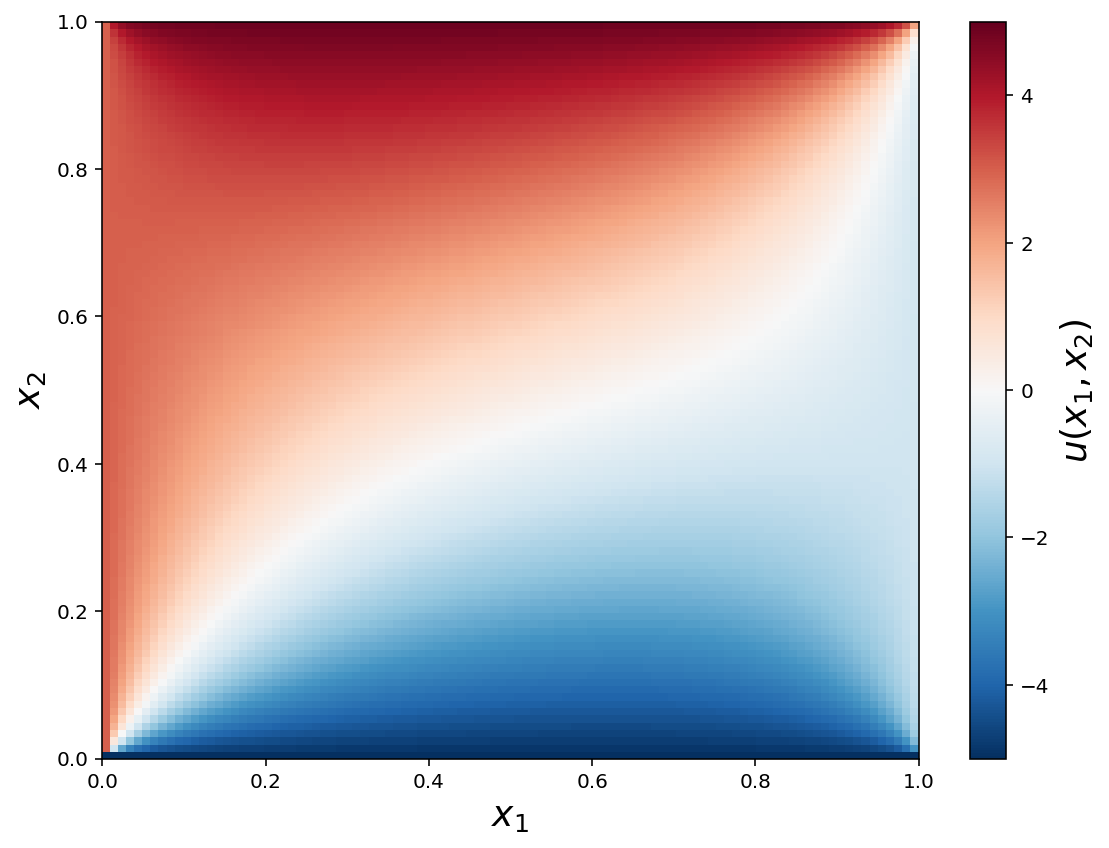

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

c = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=mpl.cm.get_cmap('RdBu_r'))
cb = plt.colorbar(c, ax=ax)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)
fig.savefig("ch11-fdm-2d.pdf")
fig.tight_layout()

In [29]:
x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

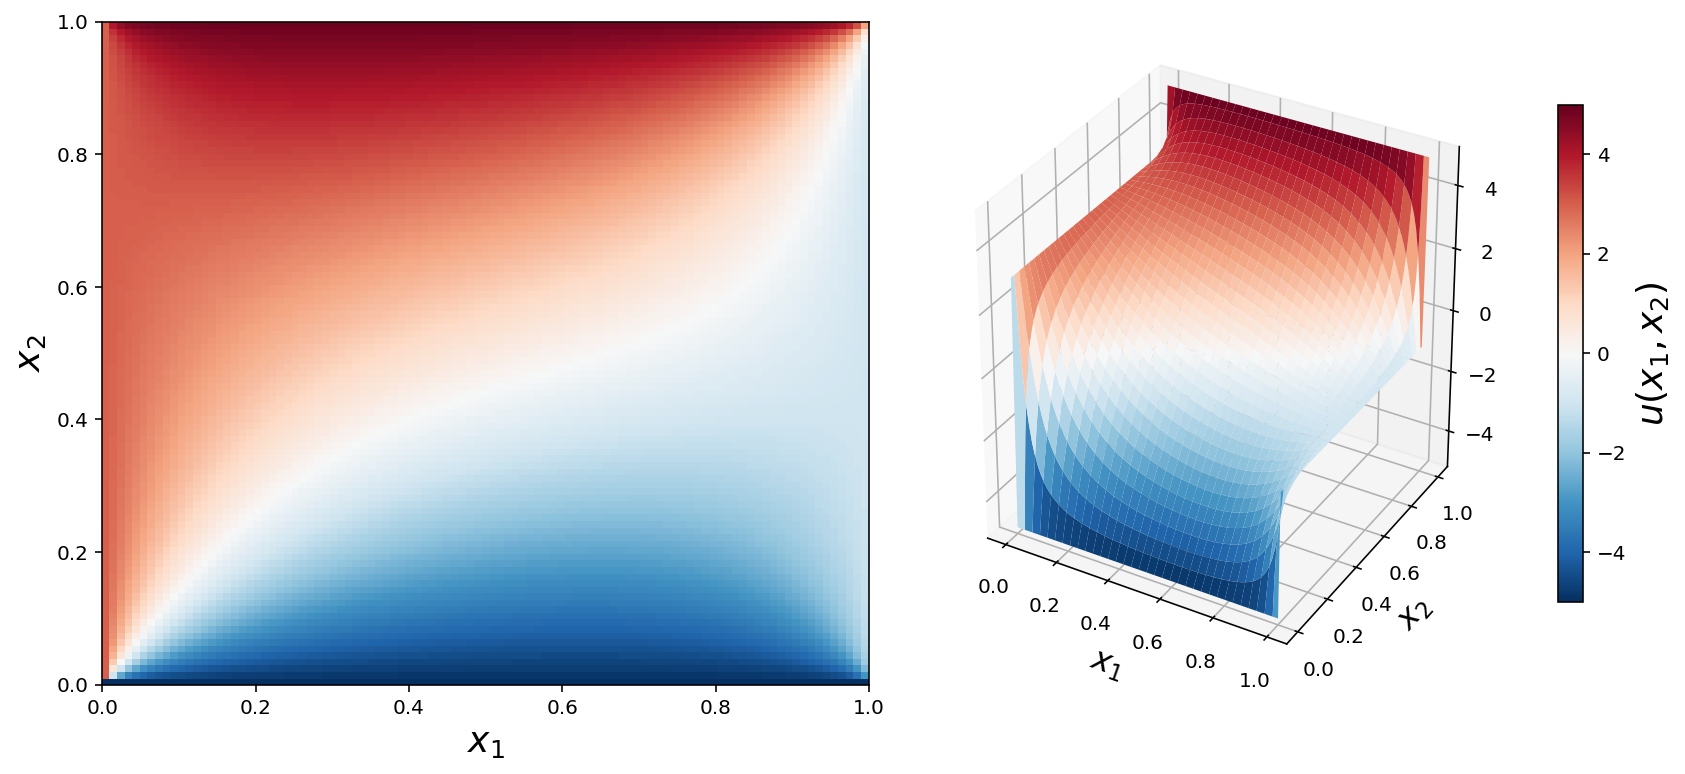

In [30]:
fig = plt.figure(figsize=(12, 5.5))
cmap = mpl.cm.get_cmap('RdBu_r')

ax = fig.add_subplot(1, 2, 1)
p = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, U, vmin=-5, vmax=5, rstride=3, cstride=3, linewidth=0, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=16)
ax.set_ylabel(r"$x_2$", fontsize=16)
cb = plt.colorbar(p, ax=ax, shrink=0.75)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

fig.savefig("ch11-fdm-2d.pdf")
fig.savefig("ch11-fdm-2d.png")
fig.tight_layout()

### Compare performance when using dense/sparse matrices

In [31]:
A_dense = A.todense()

In [32]:
%timeit np.linalg.solve(A_dense, d)

15.9 s ± 904 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit la.solve(A_dense, d)

18.3 s ± 872 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit sp.linalg.spsolve(A, d)

58.7 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
10.8 / 31.9e-3

338.5579937304076

### 2d example with source term

In [36]:
d = - np.ones((N, N))
d = d.reshape(N**2)

In [37]:
u = sp.linalg.spsolve(A, d).reshape(N, N)

In [38]:
U = np.vstack([np.zeros((1, N+2)),
               np.hstack([np.zeros((N, 1)), u, np.zeros((N, 1))]),
               np.zeros((1, N+2))])

In [39]:
x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

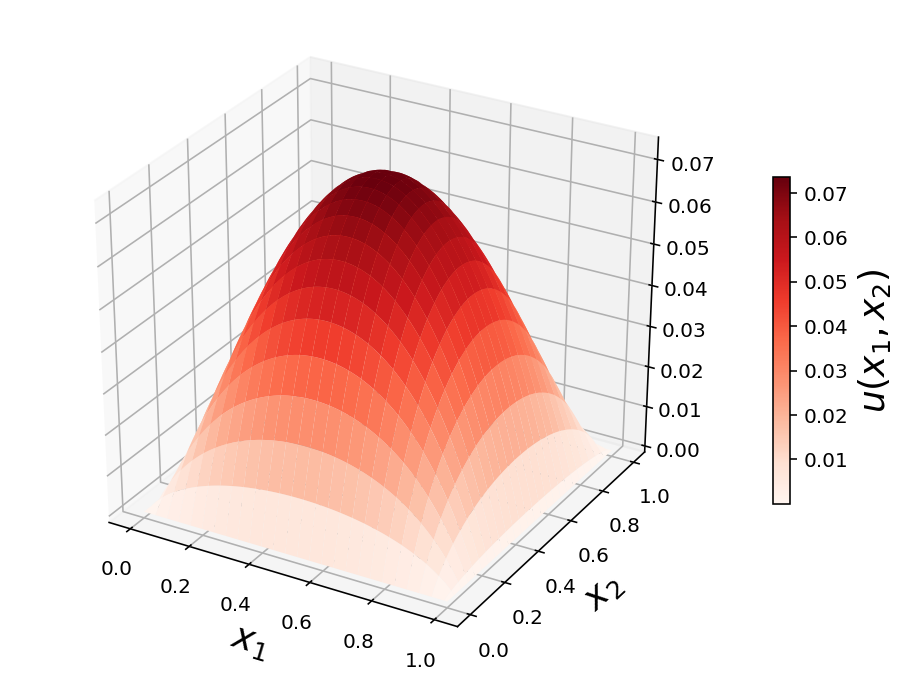

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': '3d'})

p = ax.plot_surface(X, Y, U, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, shrink=0.5)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

## FEniCS

In [41]:
import dolfin

In [42]:
import mshr

In [43]:
dolfin.parameters["reorder_dofs_serial"] = False
dolfin.parameters["allow_extrapolation"] = True

In [44]:
N1 = N2 = 75

In [45]:
mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(1, 1), N1, N2)

In [46]:
from IPython.display import display

In [47]:
dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(1, 1), 10, 10)

### Function space from mesh

In [48]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

### Variational problem

In [49]:
u = dolfin.TrialFunction(V)

In [50]:
v = dolfin.TestFunction(V)

In [51]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [52]:
f1 = dolfin.Constant(1.0)

In [53]:
L1 = f1 * v * dolfin.dx

In [54]:
f2 = dolfin.Constant(1.0)

In [176]:
# f2 = dolfin.Expression("x[0]*x[0] + x[1]*x[1]", degree=1)

In [56]:
L2 = f2 * v * dolfin.dx

### Boundary conditions

In [57]:
u0 = dolfin.Constant(0)

In [58]:
def u0_boundary(x, on_boundary):
    # try to pin down the function at some interior region:
    #if np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2) < 0.1:
    #    return True
    return on_boundary

In [59]:
bc = dolfin.DirichletBC(V, u0, u0_boundary)

### Solve the problem

In [60]:
A = dolfin.assemble(a)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/rob/miniconda3/envs/py3.6/lib/python3.6/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [61]:
b = dolfin.assemble(L1)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/rob/miniconda3/envs/py3.6/lib/python3.6/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


In [62]:
bc.apply(A, b)

In [63]:
u_sol1 = dolfin.Function(V)

In [64]:
dolfin.solve(A, u_sol1.vector(), b)

1

In [65]:
u_sol2 = dolfin.Function(V)

In [66]:
dolfin.solve(a == L2, u_sol2, bc)

### Dolfin plot

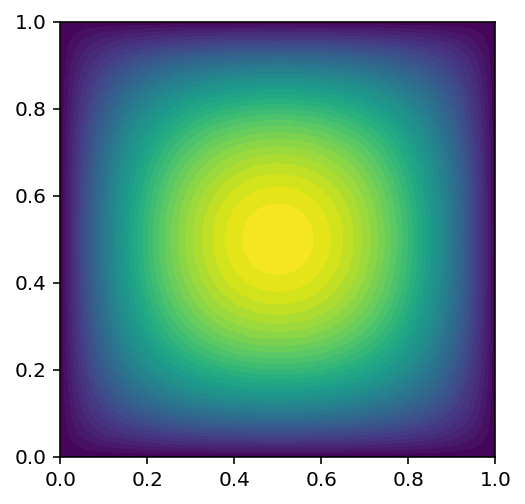

In [67]:
dolfin.plot(u_sol1)
# dolfin.interactive()

### Save VTK files

In [68]:
dolfin.File('u_sol1.pvd') << u_sol1

In [69]:
dolfin.File('u_sol2.pvd') << u_sol2

In [70]:
f = dolfin.File('combined.pvd')
f << mesh
f << u_sol1
f << u_sol2

### Function evaluation

In [71]:
u_sol1([0.21, 0.67])

0.04660769977813516

### Obtain NumPy arrays

In [72]:
u_mat1 = np.array(u_sol1.vector()).reshape(N1+1, N2+1)

In [73]:
u_mat2 = np.array(u_sol2.vector()).reshape(N1+1, N2+1)

In [74]:
X, Y = np.meshgrid(np.linspace(0, 1, N1+2), np.linspace(0, 1, N2+2))

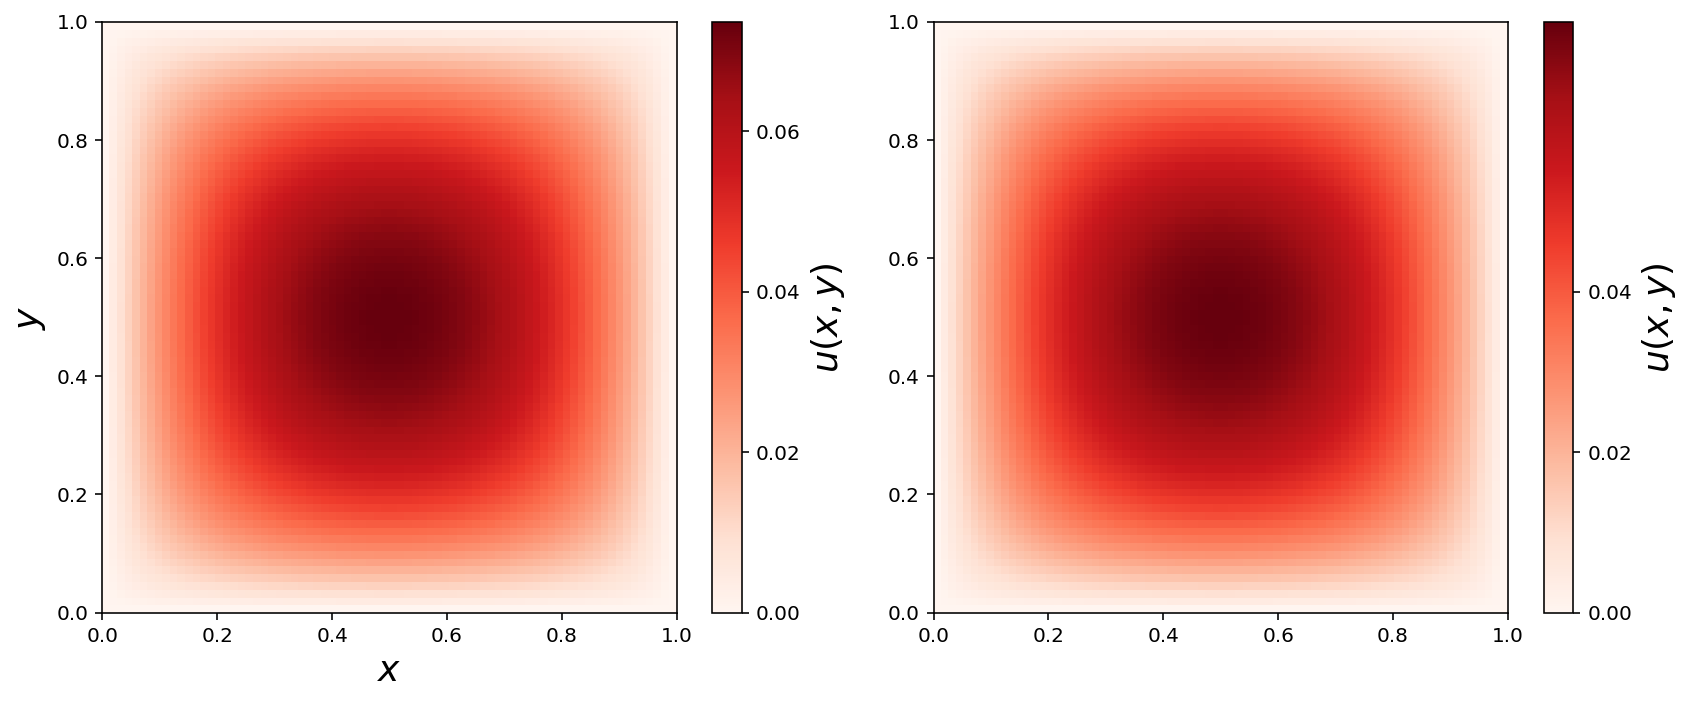

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
cmap = mpl.cm.get_cmap('Reds')

c = ax1.pcolor(X, Y, u_mat1, cmap=cmap)
cb = plt.colorbar(c, ax=ax1)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04, 0.06])

c = ax2.pcolor(X, Y, u_mat2, cmap=cmap)
cb = plt.colorbar(c, ax=ax2)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04])

fig.savefig("ch11-fdm-2d-ex1.pdf")
fig.savefig("ch11-fdm-2d-ex1.png")
fig.tight_layout()

In [76]:
X, Y = np.meshgrid(np.linspace(0, 1, N1+1), np.linspace(0, 1, N2+1))

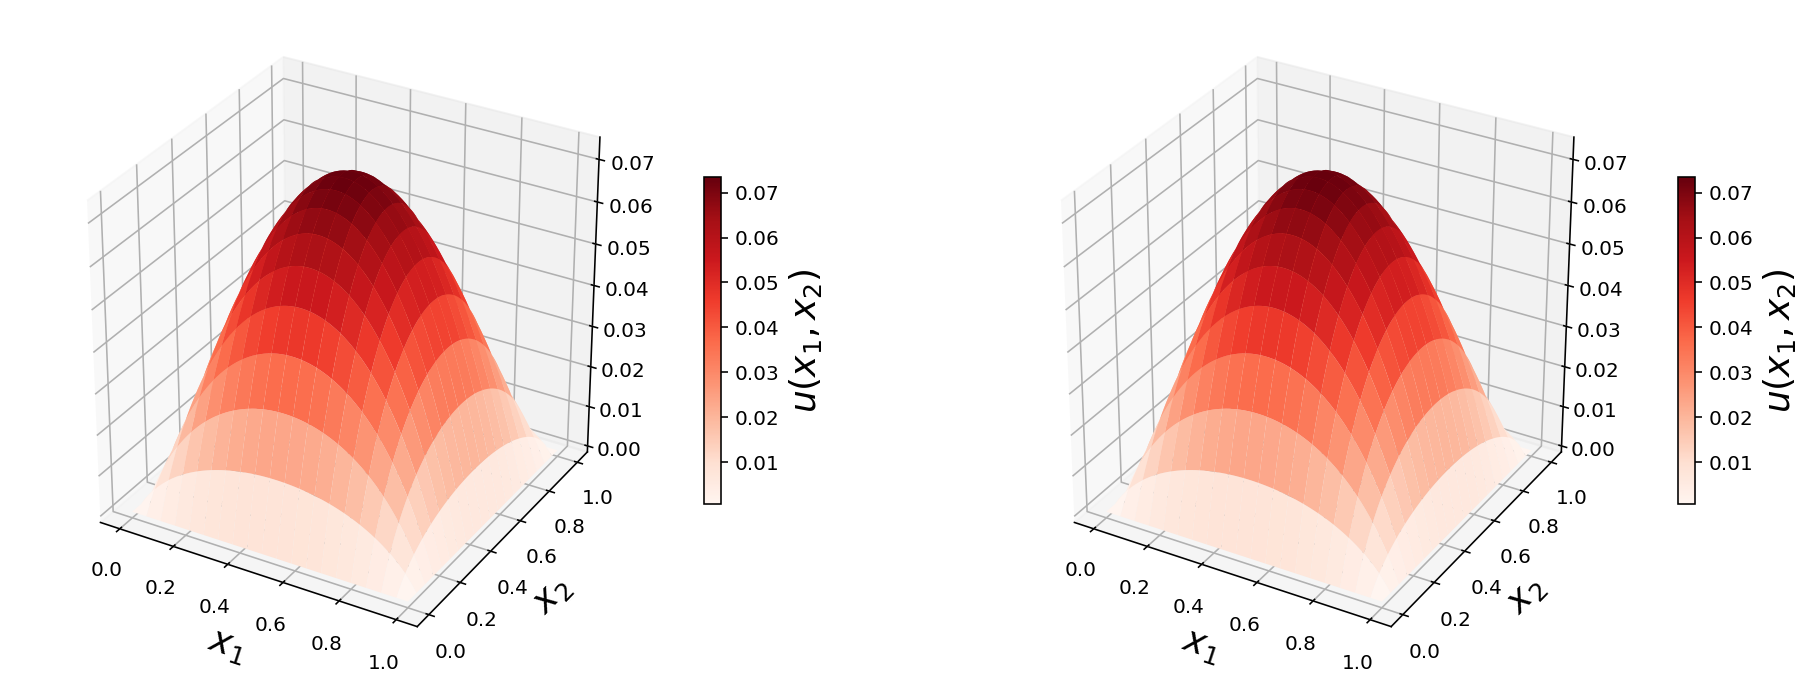

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

p = ax1.plot_surface(X, Y, u_mat1, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, ax=ax1, shrink=0.5)
ax1.set_xlabel(r"$x_1$", fontsize=18)
ax1.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

p = ax2.plot_surface(X, Y, u_mat2, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, ax=ax2, shrink=0.5)
ax2.set_xlabel(r"$x_1$", fontsize=18)
ax2.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

### Triangulation

In [78]:
def mesh_triangulation(mesh):
    coordinates = mesh.coordinates()
    triangles = mesh.cells()
    triangulation = mpl.tri.Triangulation(coordinates[:, 0], coordinates[:, 1], triangles)
    return triangulation

In [79]:
triangulation = mesh_triangulation(mesh)

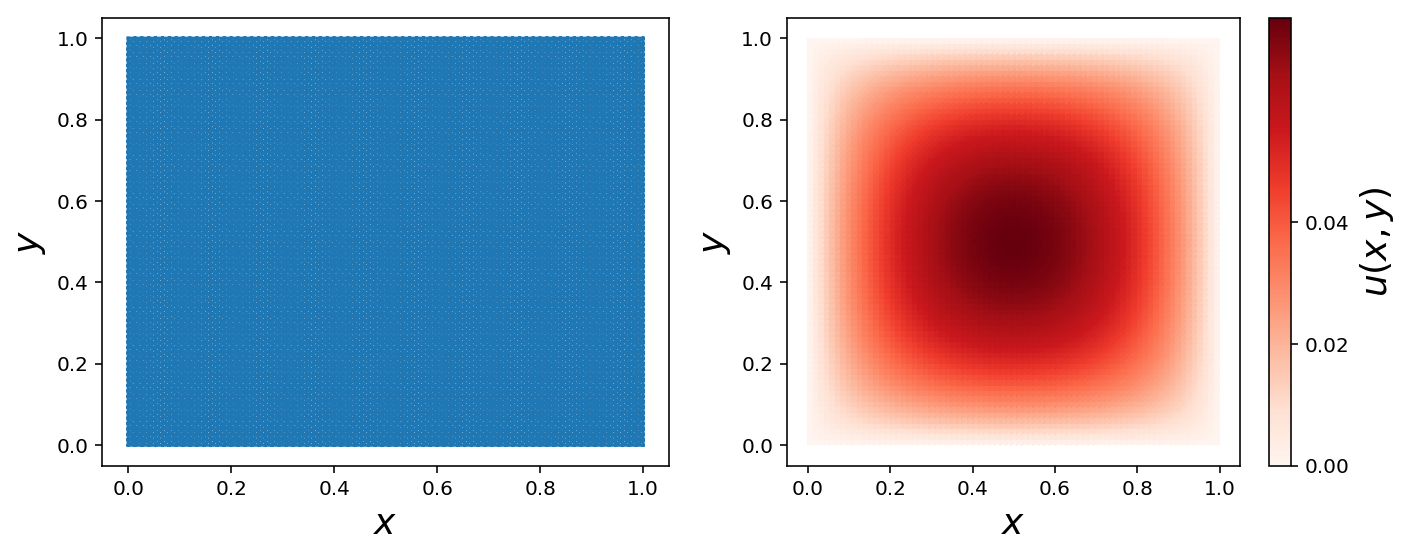

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)

c = ax2.tripcolor(triangulation, np.array(u_sol2.vector()), cmap=cmap)
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04])

fig.savefig("ch11-fdm-2d-ex2.pdf")
fig.savefig("ch11-fdm-2d-ex2.png")
fig.tight_layout()

## Dirichlet boundary conditions

In [81]:
N1 = N2 = 75

In [82]:
mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(1, 1), N1, N2)

In [83]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

In [84]:
u = dolfin.TrialFunction(V)

In [85]:
v = dolfin.TestFunction(V)

In [86]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [87]:
f = dolfin.Constant(0.0)

In [88]:
L = f * v * dolfin.dx

In [89]:
def u0_top_boundary(x, on_boundary):
    return on_boundary and abs(x[1]-1) < 1e-8

In [90]:
def u0_bottom_boundary(x, on_boundary):
    return on_boundary and abs(x[1]) < 1e-8

In [91]:
def u0_left_boundary(x, on_boundary):
    return on_boundary and abs(x[0]) < 1e-8

In [92]:
def u0_right_boundary(x, on_boundary):
    return on_boundary and abs(x[0]-1) < 1e-8

In [93]:
bc_t = dolfin.DirichletBC(V, dolfin.Constant(5), u0_top_boundary)
bc_b = dolfin.DirichletBC(V, dolfin.Constant(-5), u0_bottom_boundary)
bc_l = dolfin.DirichletBC(V, dolfin.Constant(3), u0_left_boundary)
bc_r = dolfin.DirichletBC(V, dolfin.Constant(-1), u0_right_boundary)

In [94]:
bcs = [bc_t, bc_b, bc_r, bc_l]

In [95]:
u_sol = dolfin.Function(V)

In [96]:
dolfin.solve(a == L, u_sol, bcs)

In [97]:
u_mat = np.array(u_sol.vector()).reshape(N1+1, N2+1)

In [98]:
x = np.linspace(0, 1, N1+2)
y = np.linspace(0, 1, N1+2)
X, Y = np.meshgrid(x, y)

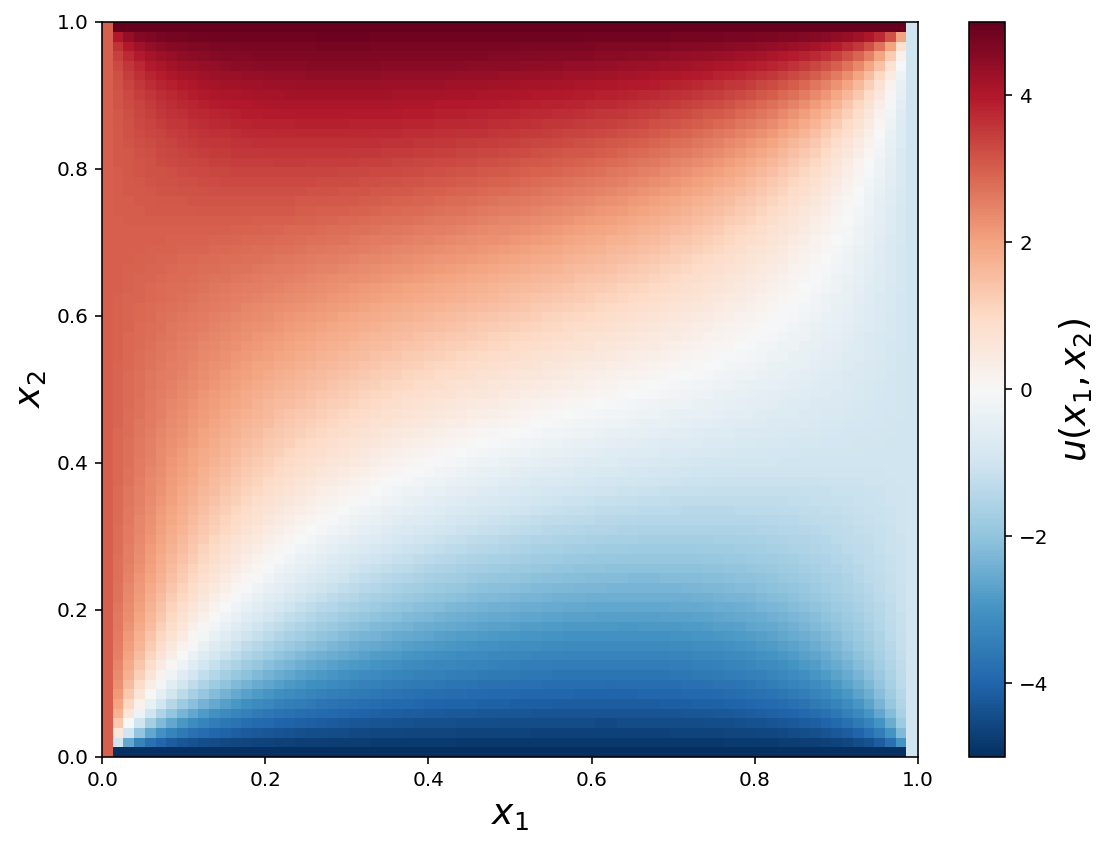

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

c = ax.pcolor(X, Y, u_mat, vmin=-5, vmax=5, cmap=mpl.cm.get_cmap('RdBu_r'))
cb = plt.colorbar(c, ax=ax)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)
fig.savefig("ch11-fdm-2d-ex3.pdf")
fig.savefig("ch11-fdm-2d-ex3.png")
fig.tight_layout()

## Circular geometry

In [100]:
r_outer = 1
r_inner = 0.25
r_middle = 0.1
x0, y0 = 0.4, 0.4

In [101]:
domain = mshr.Circle(dolfin.Point(.0, .0), r_outer) \
    - mshr.Circle(dolfin.Point(.0, .0), r_inner) \
    - mshr.Circle(dolfin.Point( x0,  y0), r_middle) \
    - mshr.Circle(dolfin.Point( x0, -y0), r_middle) \
    - mshr.Circle(dolfin.Point(-x0,  y0), r_middle) \
    - mshr.Circle(dolfin.Point(-x0, -y0), r_middle)

In [102]:
mesh = mshr.generate_mesh(domain, 10)

In [103]:
mesh

In [104]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

In [105]:
u = dolfin.TrialFunction(V)

In [106]:
v = dolfin.TestFunction(V)

In [107]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [108]:
f = dolfin.Constant(1.0)

In [109]:
L = f * v * dolfin.dx

In [110]:
def u0_outer_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2) - r_outer) < 5e-2

In [111]:
def u0_inner_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2) - r_inner) < 5e-2

In [112]:
def u0_middle_boundary(x, on_boundary):
    x, y = x[0], x[1]
    if on_boundary:
        for _x0 in [-x0, x0]:
            for _y0 in [-y0, y0]:
                if abs(np.sqrt((x+_x0)**2 + (y+_y0)**2) - r_middle) < 5e-2:
                    return True
    
    return False

In [113]:
bc_inner = dolfin.DirichletBC(V, dolfin.Constant(15), u0_inner_boundary)
bc_middle = dolfin.DirichletBC(V, dolfin.Constant(0), u0_middle_boundary)

In [114]:
bcs = [bc_inner, bc_middle]

In [115]:
u_sol = dolfin.Function(V)

In [116]:
dolfin.solve(a == L, u_sol, bcs)

In [117]:
triangulation = mesh_triangulation(mesh)

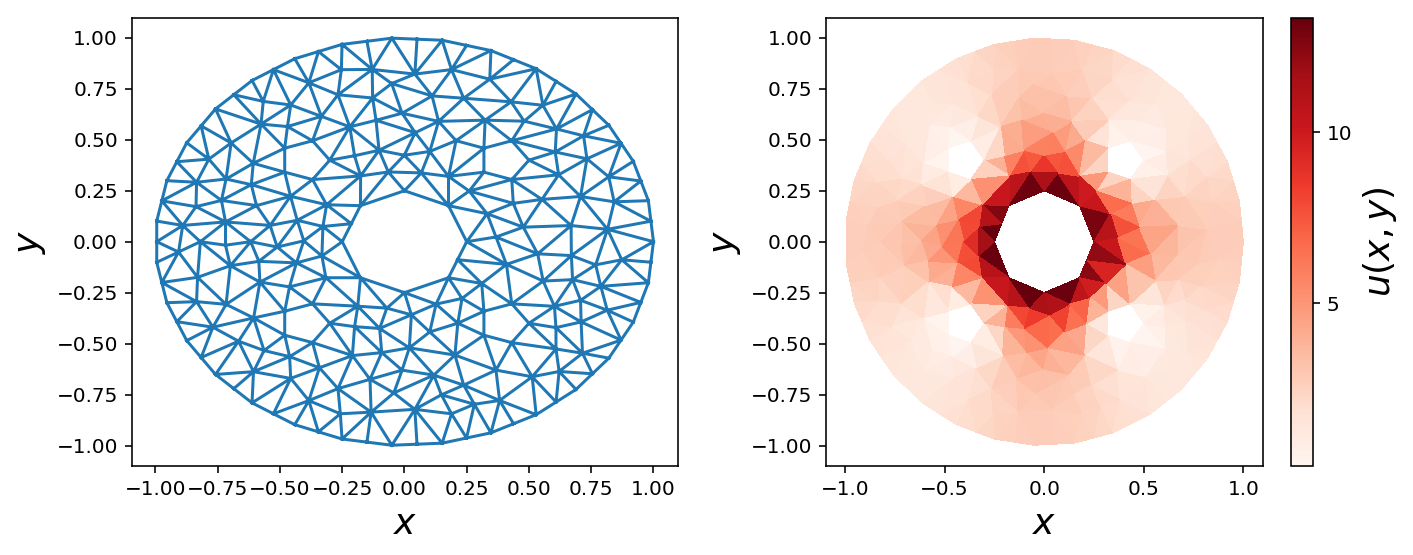

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)

c = ax2.tripcolor(triangulation, np.array(u_sol.vector()), cmap=mpl.cm.get_cmap("Reds"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 5, 10, 15])

fig.savefig("ch11-fdm-2d-ex4.pdf")
fig.savefig("ch11-fdm-2d-ex4.png")
fig.tight_layout()

### Post processing

In [119]:
outer_boundary = dolfin.AutoSubDomain(lambda x, on_bnd: on_bnd and abs(np.sqrt(x[0]**2 + x[1]**2) - r_outer) < 5e-2)

In [120]:
bc_outer = dolfin.DirichletBC(V, 1, outer_boundary)

In [121]:
mask_outer = dolfin.Function(V)

In [122]:
bc_outer.apply(mask_outer.vector())

In [123]:
u_outer = u_sol.vector()[mask_outer.vector() == 1]

In [124]:
x_outer = mesh.coordinates()[mask_outer.vector() == 1]

In [125]:
phi = np.angle(x_outer[:, 0] + 1j * x_outer[:, 1])

In [126]:
order = np.argsort(phi)

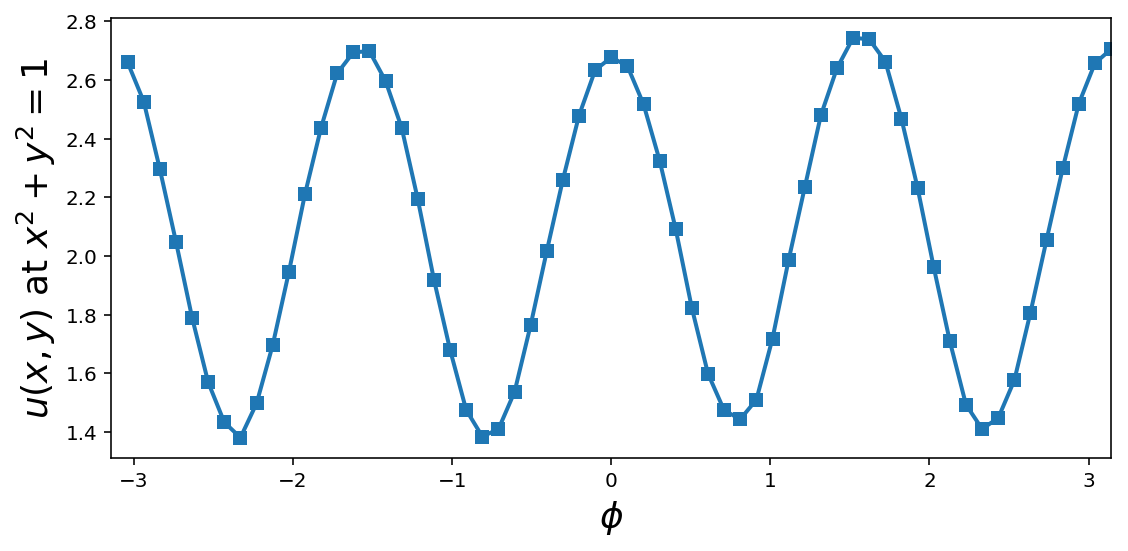

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(phi[order], u_outer[order], 's-', lw=2)
ax.set_ylabel(r"$u(x,y)$ at $x^2+y^2=1$", fontsize=18)
ax.set_xlabel(r"$\phi$", fontsize=18)
ax.set_xlim(-np.pi, np.pi)
fig.tight_layout()
fig.savefig("ch11-fem-2d-ex5.pdf")

## Mesh refining

In [128]:
domain = mshr.Circle(dolfin.Point(.0, .0), 1.0) - mshr.Rectangle(dolfin.Point(0.0, -1.0), dolfin.Point(1.0, 0.0))

In [129]:
mesh = mshr.generate_mesh(domain, 10)

In [131]:
refined_mesh = mesh
for r in [0.5, 0.25]:
    cell_markers = dolfin.MeshFunction("bool", refined_mesh, 2)
    cell_markers.set_all(False)
    for cell in dolfin.cells(refined_mesh):
        if cell.distance(dolfin.Point(.0, .0)) < r:
            cell_markers[cell] = True
    refined_mesh = dolfin.refine(refined_mesh, cell_markers)

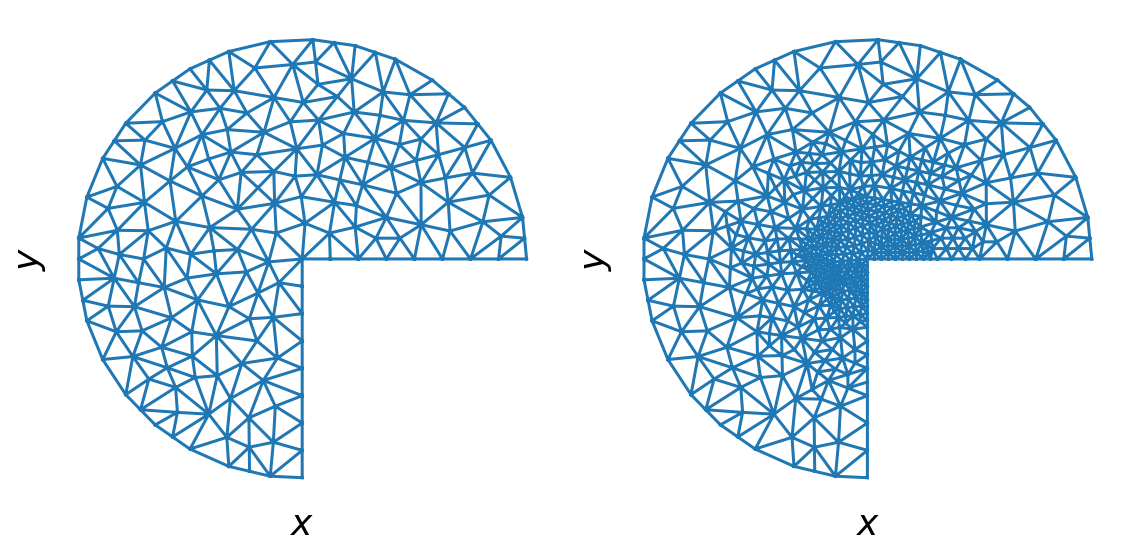

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
 
ax1.triplot(mesh_triangulation(mesh))
ax2.triplot(mesh_triangulation(refined_mesh))

for ax in [ax1, ax2]:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

    ax.set_xlabel(r"$x$", fontsize=18)
    ax.set_ylabel(r"$y$", fontsize=18)
 
fig.savefig("ch11-fem-2d-mesh-refine.pdf")
fig.savefig("ch11-fem-2d-mesh-refine.png")
fig.tight_layout()

### Refined mesh with Dirichlet boundary conditions

In [133]:
mesh = refined_mesh

In [134]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

In [135]:
u = dolfin.TrialFunction(V)

In [136]:
v = dolfin.TestFunction(V)

In [137]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [138]:
f = dolfin.Constant(0.0)

In [139]:
L = f * v * dolfin.dx

In [140]:
def u0_vertical_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(x) < 1e-2 and y < 0.0

In [141]:
def u0_horizontal_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(y) < 1e-2 and x > 0.0

In [142]:
bc_vertical = dolfin.DirichletBC(V, dolfin.Constant(-5), u0_vertical_boundary)

In [143]:
bc_horizontal = dolfin.DirichletBC(V, dolfin.Constant(5), u0_horizontal_boundary)

In [144]:
bcs = [bc_vertical, bc_horizontal]

In [145]:
u_sol = dolfin.Function(V)

In [146]:
dolfin.solve(a == L, u_sol, bcs)

In [147]:
triangulation = mesh_triangulation(mesh)

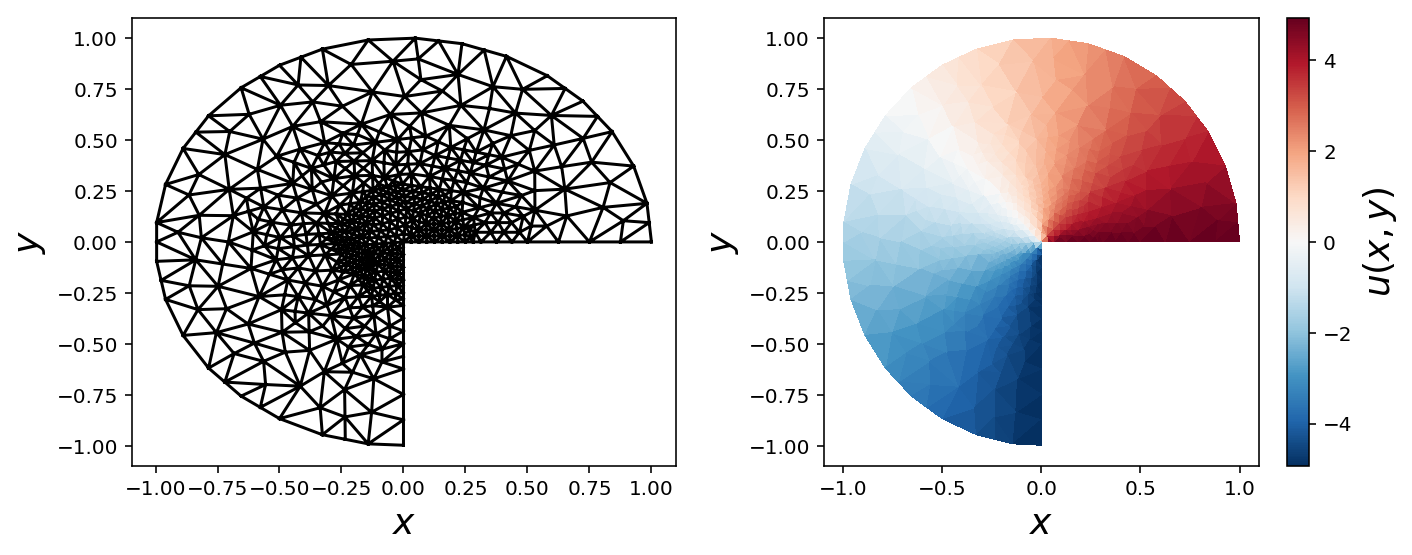

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
 
ax1.triplot(triangulation, color='k')
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
 
c = ax2.tripcolor(triangulation, np.array(u_sol.vector()), cmap=mpl.cm.get_cmap("RdBu_r"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)

fig.tight_layout()

## Refined mesh with Dirichlet and von Neumann boundary conditions

In [149]:
mesh = refined_mesh

In [150]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

In [151]:
u = dolfin.TrialFunction(V)

In [152]:
v = dolfin.TestFunction(V)

In [153]:
boundary_parts = dolfin.MeshFunction("size_t", mesh, mesh.topology().dim()-1)

In [154]:
def v_boundary_func(x, on_boundary):
    """ the vertical edge of the mesh, where x = 0 and y < 0"""
    x, y = x[0], x[1]
    return on_boundary and abs(x) < 1e-4 and y < 0.0

In [155]:
v_boundary = dolfin.AutoSubDomain(v_boundary_func)

In [156]:
v_boundary.mark(boundary_parts, 0)

In [157]:
def h_boundary_func(x, on_boundary):
    """ the horizontal edge of the mesh, where y = 0 and x > 0"""
    x, y = x[0], x[1]
    return on_boundary and abs(y) < 1e-4 and x > 0.0

In [158]:
h_boundary = dolfin.AutoSubDomain(h_boundary_func)

In [159]:
h_boundary.mark(boundary_parts, 1)

In [160]:
def outer_boundary_func(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(x**2 + y**2-1) < 1e-2

In [161]:
outer_boundary = dolfin.AutoSubDomain(outer_boundary_func)

In [162]:
outer_boundary.mark(boundary_parts, 2)

In [163]:
bc = dolfin.DirichletBC(V, dolfin.Constant(0.0), boundary_parts, 2)

In [164]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx(domain=mesh, subdomain_data=boundary_parts)

In [165]:
f = dolfin.Constant(0.0)

In [166]:
g_v = dolfin.Constant(-2.0)

In [167]:
g_h = dolfin.Constant(1.0)

In [168]:
L = f * v * dolfin.dx(domain=mesh, subdomain_data=boundary_parts)

In [169]:
L += g_v * v * dolfin.ds(0, domain=mesh, subdomain_data=boundary_parts)

In [170]:
L += g_h * v * dolfin.ds(1, domain=mesh, subdomain_data=boundary_parts)

In [171]:
u_sol = dolfin.Function(V)

In [172]:
dolfin.solve(a == L, u_sol, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/rob/miniconda3/envs/py3.6/lib/python3.6/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


In [173]:
triangulation = mesh_triangulation(mesh)

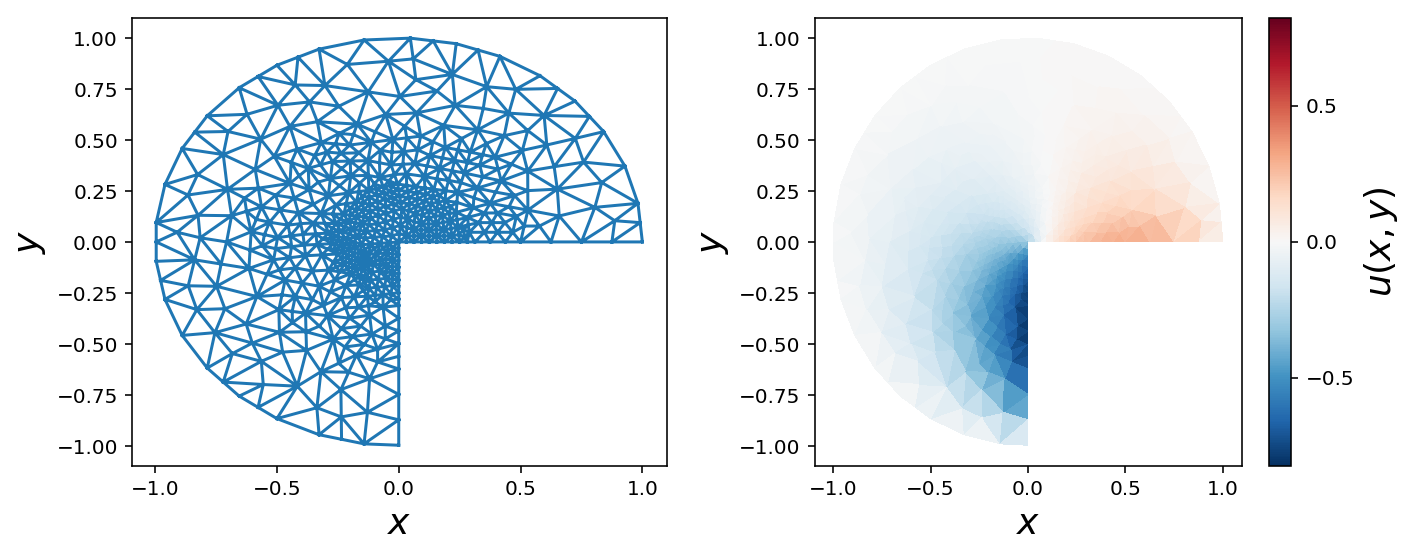

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
 
ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
 
data = np.array(u_sol.vector())
norm = mpl.colors.Normalize(-abs(data).max(), abs(data).max())
c = ax2.tripcolor(triangulation, data, norm=norm, cmap=mpl.cm.get_cmap("RdBu_r"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([-.5, 0, .5])
 
fig.savefig("ch11-fem-2d-ex5.pdf")
fig.savefig("ch11-fem-2d-ex5.png")
fig.tight_layout()

## Versions

In [175]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, dolfin

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.5.0
OS Darwin 18.5.0 x86_64 i386 64bit
numpy 1.15.4
scipy 1.2.1
matplotlib 3.0.3
dolfin 2018.1.0
Sat May 25 22:36:07 2019 JST